# Setup

In [1]:
from google.colab import drive

drive.mount('/content/drive')
drive_path = 'drive/MyDrive'

Mounted at /content/drive


In [2]:
import pandas as pd

#df_sup = pd.read_csv('electricity_price_hourly_supplier_fix.csv', index_col = 'date')
df_sup = pd.read_csv(f'{drive_path}/electricity_price_hourly_supplier_fix.csv', index_col = 'date')
df_sup

,year,quarter,month,week_of_year,day_of_year,day_of_week,day,hour,supplier_price
date,,,,,,,,,
2019-05-27 00:00:00+00:00,2019,2,5,22,147,0,27,0,949.90
2019-05-27 01:00:00+00:00,2019,2,5,22,147,0,27,1,942.20
2019-05-27 02:00:00+00:00,2019,2,5,22,147,0,27,2,952.14
2019-05-27 03:00:00+00:00,2019,2,5,22,147,0,27,3,944.93
2019-05-27 04:00:00+00:00,2019,2,5,22,147,0,27,4,966.00
...,...,...,...,...,...,...,...,...,...
2024-05-27 19:00:00+00:00,2024,2,5,22,148,0,27,19,1227.36
2024-05-27 20:00:00+00:00,2024,2,5,22,148,0,27,20,1010.99
2024-05-27 21:00:00+00:00,2024,2,5,22,148,0,27,21,936.12


In [4]:
import random
import numpy as np

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [6]:
NUM_OF_SPLITS = 10
TARGET_COLUMN = 'supplier_price'

In [7]:
rows_count = len(df_sup)
proportion = 0.80
train_count = int(rows_count * proportion)
test_count = rows_count - train_count
train = df_sup[:train_count].copy()
test = df_sup[train_count:train_count + test_count].copy()
print(f'Train: {len(train)}')
print(f'Test: {len(test)}')

Train: 35097
Test: 8775


In [5]:
!pip install catboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.5 MB/s eta 0:00:00


In [8]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [9]:
class ConstantRegressor:
    def __init__(self):
        self.constant = 0
        self.is_fit = False

    def fit(self, x_train, y_train):
        if len(x_train) != len(y_train):
            raise Exception('Train and test sequences have different lengths!')
        self.constant = y_train.iloc[0][0]
        self.is_fit = True

    def predict(self, x_test):
        if self.is_fit == False:
            raise Exception('Predictor was not trained!')
        return np.array([self.constant] * len(x_test))


class DriftRegressor:
    def __init__(self):
        self.y_0 = 0
        self.y_1 = 0
        self.is_fit = False

    def fit(self, x_train, y_train):
        if len(x_train) != len(y_train):
            raise Exception('Train and test sequences have different lengths!')
        self.y_0 = y_train.iloc[0][0]
        self.y_1 = y_train.iloc[-1][0]
        self.is_fit = True

    def predict(self, x_test):
        if self.is_fit == False:
            raise Exception('Predictor was not trained!')
        output = []
        if len(x_test) <= 1:
            output.append(self.y_0)
            return output
        x_0 = 0
        x_1 = len(x_test)
        l = abs(x_1 - x_0)
        dy = (self.y_1 - self.y_0) / l
        y = self.y_0
        i = 1
        while i <= l:
            output.append(y)
            y += dy
            i += 1
        return np.array(output)

# Feature importance based on permutation importance (any fitted model)

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
train_scaled = pd.DataFrame(train_scaled, columns = train.columns, index = train.index)
test_scaled = scaler.transform(test)
test_scaled = pd.DataFrame(test_scaled, columns = test.columns, index = test.index)

x_train, y_train = train_scaled.drop(columns = TARGET_COLUMN), train_scaled[[TARGET_COLUMN]]
x_test, y_test = test_scaled.drop(columns = TARGET_COLUMN), test_scaled[[TARGET_COLUMN]]

## ML models

In [11]:
models = []
models.append(('Naive', ConstantRegressor()))
models.append(('Drift', DriftRegressor()))
models.append(('Average', DummyRegressor(strategy = 'mean')))
models.append(('LR', LinearRegression(fit_intercept = False)))
models.append(('Bayesian R.', BayesianRidge(fit_intercept = False)))
models.append(('PAR', PassiveAggressiveRegressor(
    max_iter = 100,
    random_state = RANDOM_STATE,
    tol = 1e-3,
    fit_intercept = False)))
models.append(('SGD', SGDRegressor(random_state = RANDOM_STATE, shuffle = False, fit_intercept = False)))
models.append(('SVR', SVR(max_iter = 100)))
models.append(('Lin. SVR', LinearSVR(max_iter = 100, random_state = RANDOM_STATE, fit_intercept = False)))
models.append(('KNN', KNeighborsRegressor(n_neighbors = 20, n_jobs = -1)))
models.append(('CART', DecisionTreeRegressor(random_state = RANDOM_STATE)))
models.append(('RF', RandomForestRegressor(n_jobs = -1, random_state = RANDOM_STATE, bootstrap = False)))
models.append(('RF w/B.', RandomForestRegressor(n_jobs = -1, random_state = RANDOM_STATE, bootstrap = True)))
models.append(('XT', ExtraTreesRegressor(n_jobs = -1, random_state = RANDOM_STATE, bootstrap = False)))
models.append(('XT w/B.', ExtraTreesRegressor(n_jobs = -1, random_state = RANDOM_STATE, bootstrap = True)))
models.append(('BAG', BaggingRegressor(n_jobs = -1, random_state = RANDOM_STATE, bootstrap = False)))
models.append(('BAG w/B.', BaggingRegressor(n_jobs = -1, random_state = RANDOM_STATE, bootstrap = True)))
models.append(('ADA', AdaBoostRegressor(random_state = RANDOM_STATE)))
models.append(('HGBoost', HistGradientBoostingRegressor(random_state = RANDOM_STATE)))
models.append(('XGBoost', XGBRegressor(tree_method = 'gpu_hist', verbosity = 0, random_state = RANDOM_STATE)))
models.append(('CatBoost', CatBoostRegressor(
    random_seed = RANDOM_STATE,
    loss_function = 'RMSE',
    eval_metric = 'MAE',
    od_type = 'Iter',
    od_wait = 20,
    task_type = 'GPU',
    logging_level = 'Silent')))

----------------
Naive model...


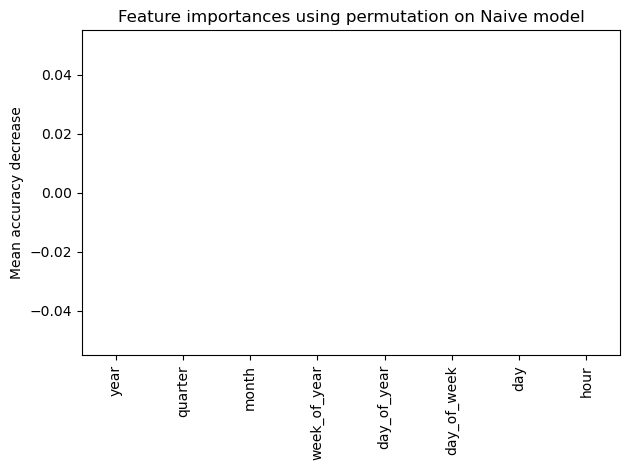

----------------
Drift model...


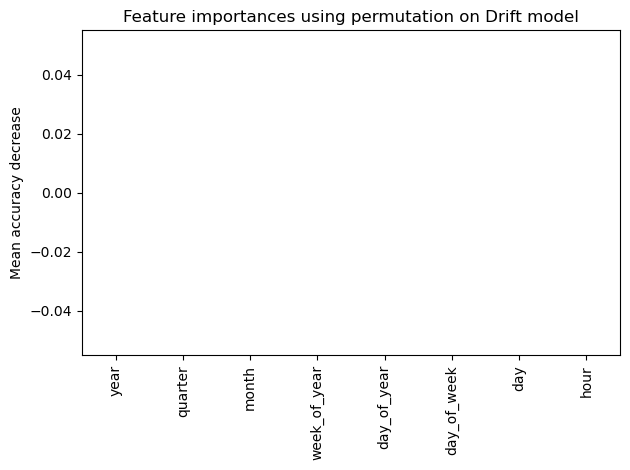

----------------
Average model...


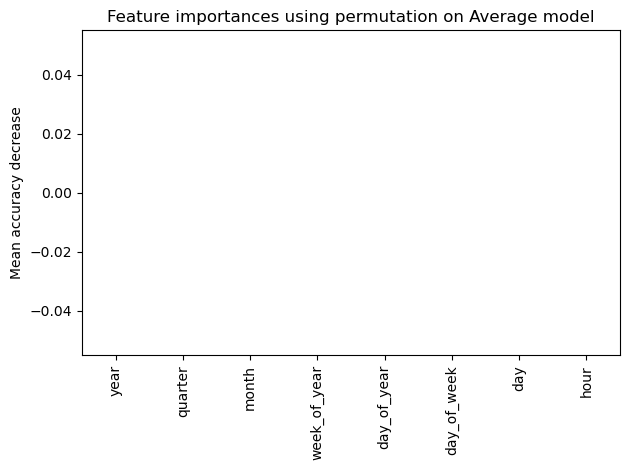

----------------
LR model...


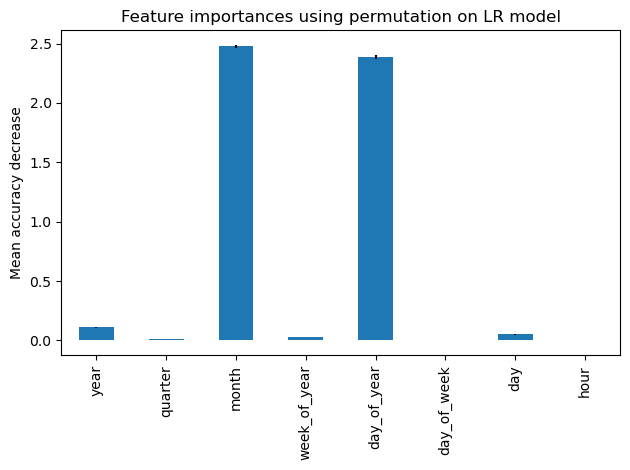

----------------
Bayesian R. model...


C:\Users\dexp\miniconda3\envs\energy\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


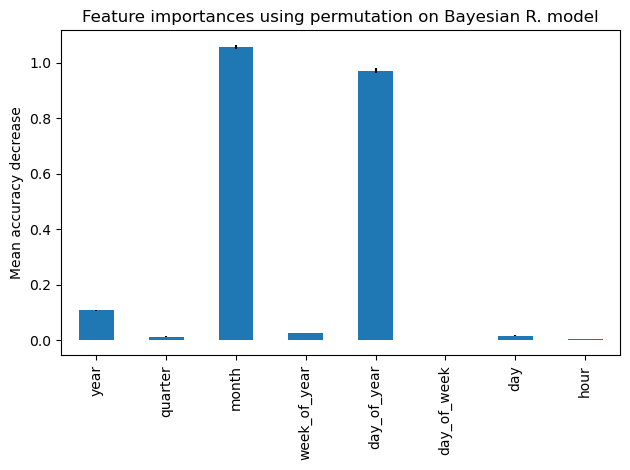

----------------
PAR model...


C:\Users\dexp\miniconda3\envs\energy\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


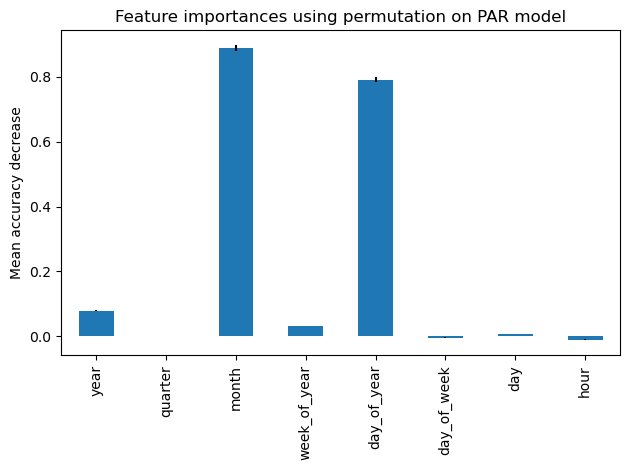

----------------
SGD model...


C:\Users\dexp\miniconda3\envs\energy\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


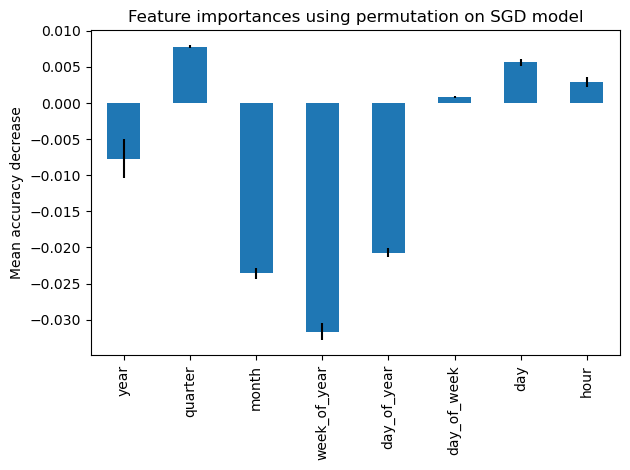

----------------
SVR model...


C:\Users\dexp\miniconda3\envs\energy\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dexp\miniconda3\envs\energy\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


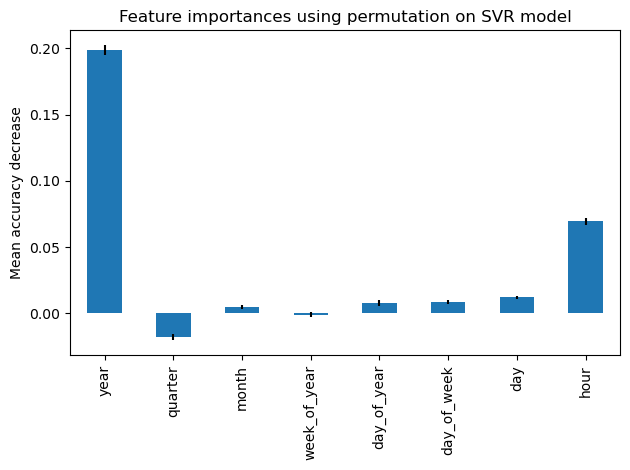

----------------
Lin. SVR model...


C:\Users\dexp\miniconda3\envs\energy\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dexp\miniconda3\envs\energy\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


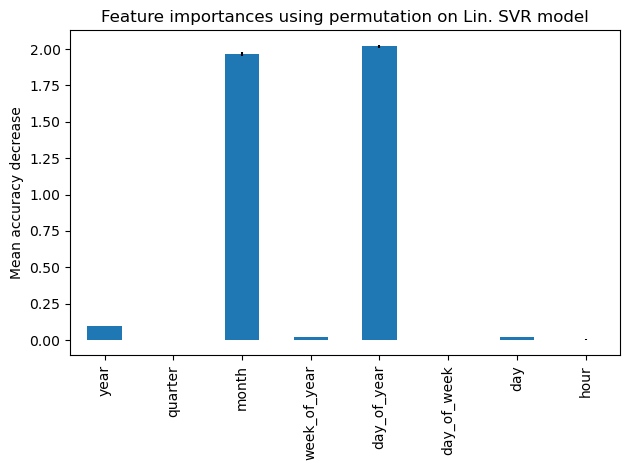

----------------
KNN model...


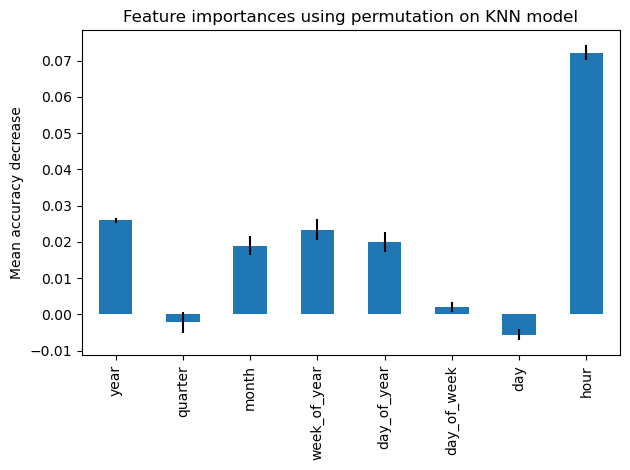

----------------
CART model...


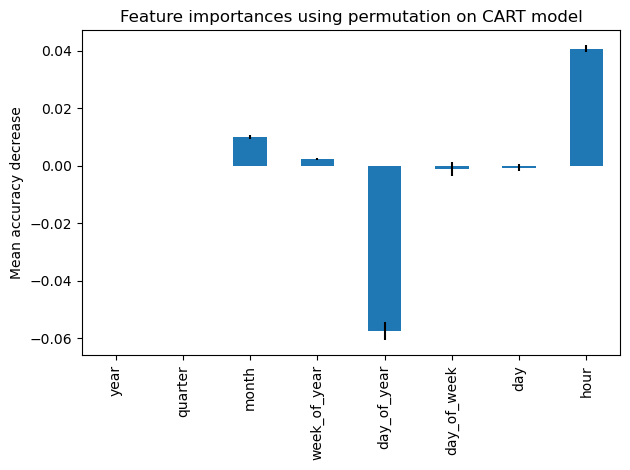

----------------
RF model...


C:\Users\dexp\AppData\Local\Temp\ipykernel_14528\709259416.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


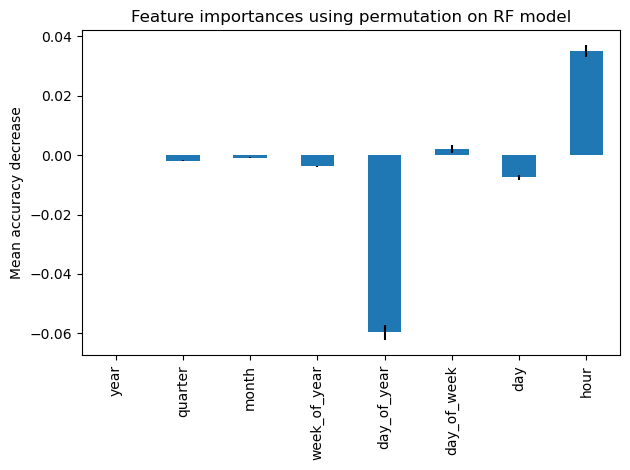

----------------
RF w/B. model...


C:\Users\dexp\AppData\Local\Temp\ipykernel_14528\709259416.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


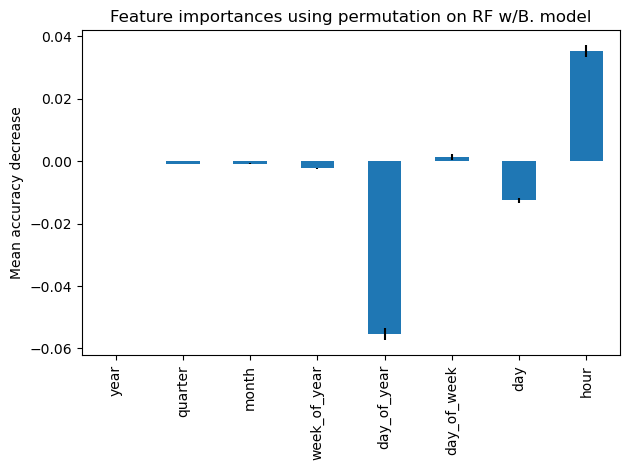

----------------
XT model...


C:\Users\dexp\AppData\Local\Temp\ipykernel_14528\709259416.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


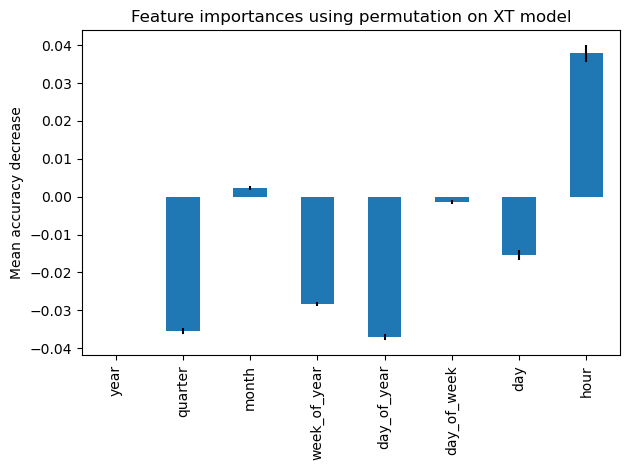

----------------
XT w/B. model...


C:\Users\dexp\AppData\Local\Temp\ipykernel_14528\709259416.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


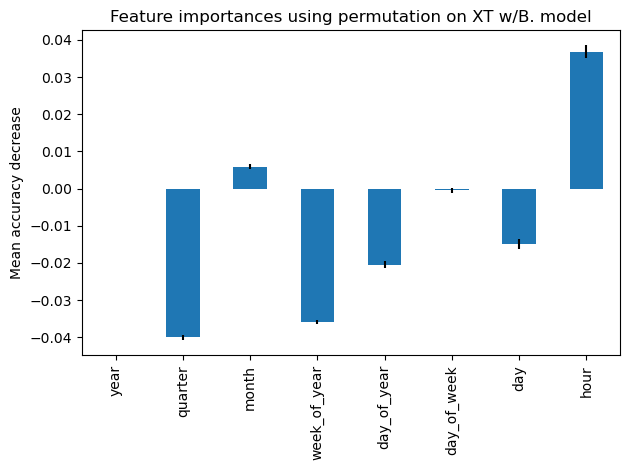

----------------
BAG model...


C:\Users\dexp\miniconda3\envs\energy\lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


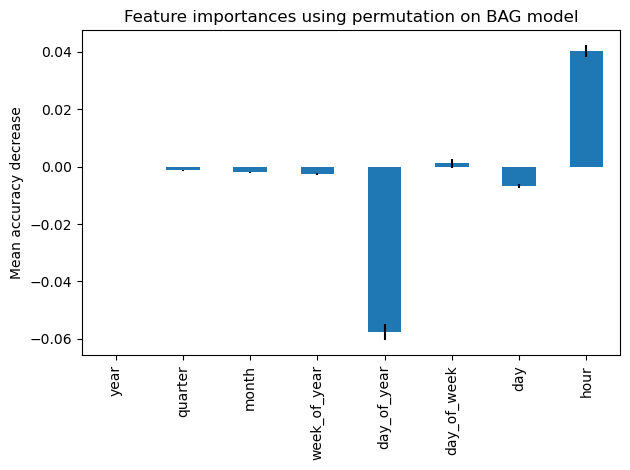

----------------
BAG w/B. model...


C:\Users\dexp\miniconda3\envs\energy\lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


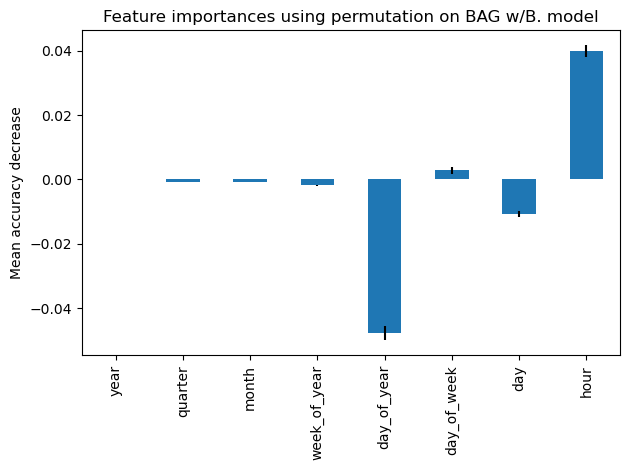

----------------
ADA model...


C:\Users\dexp\miniconda3\envs\energy\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


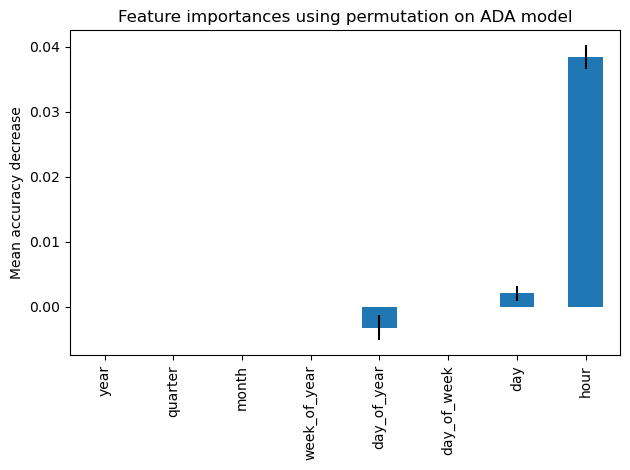

----------------
HGBoost model...


C:\Users\dexp\miniconda3\envs\energy\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


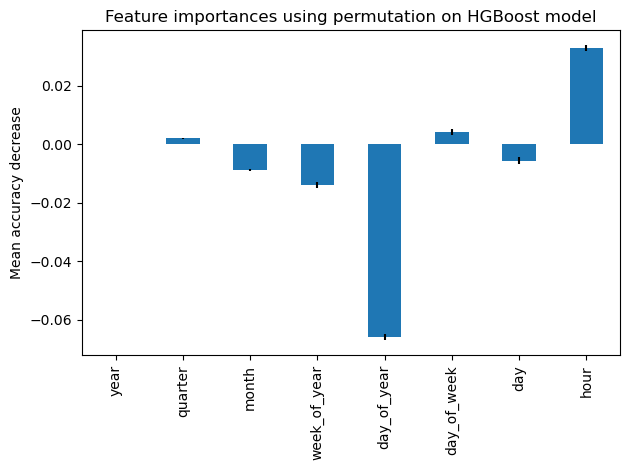

----------------
XGBoost model...


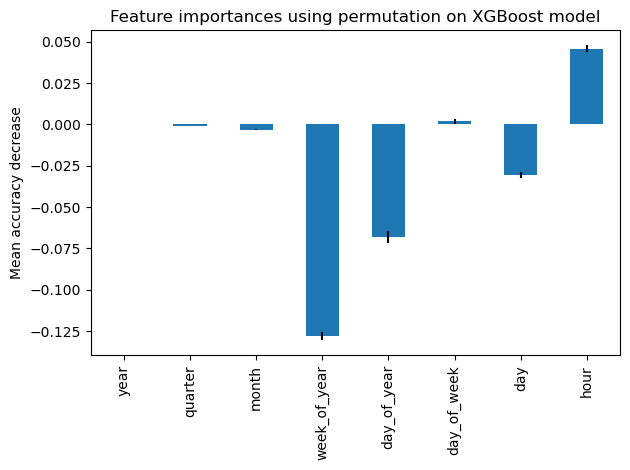

----------------
CatBoost model...


Default metric period is 5 because MAE is/are not implemented for GPU


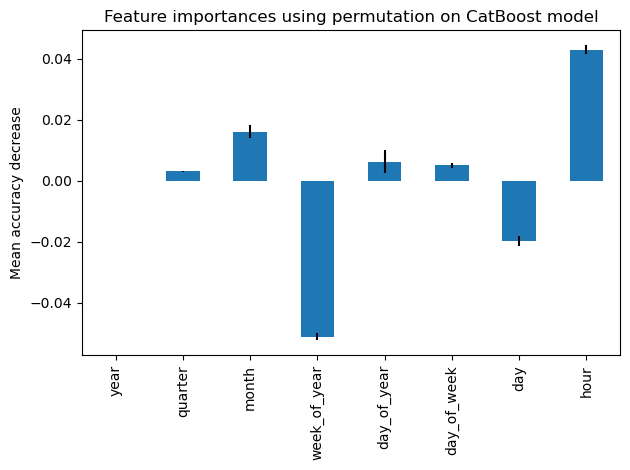

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

for name, model in models:
    print('----------------')
    print(f'{name} model...')
    model.fit(x_train, y_train)
    result = permutation_importance(
        model,
        x_test,
        y_test,
        scoring = 'neg_mean_absolute_error',
        n_repeats = NUM_OF_SPLITS,
        random_state = RANDOM_STATE,
        n_jobs = -1)
    forest_importances = pd.Series(result.importances_mean, index = list(x_test.columns))
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr = result.importances_std, ax = ax)
    ax.set_title(f'Feature importances using permutation on {name} model')
    ax.set_ylabel('Mean accuracy decrease')
    fig.tight_layout()
    plt.show()
    '''
    y_pred = model.predict(x_test)
    pred = x_test.copy()
    pred[TARGET_COLUMN] = y_pred
    pred = scaler.inverse_transform(pred)
    pred = pd.DataFrame(pred, columns = test.columns, index = test.index)
    y_pred = pred[TARGET_COLUMN]
    y_test = test[TARGET_COLUMN]
    show_regression_chart(y_test, y_pred, sort = False)
    print(f'Last {LATEST_PRED_AMOUNT} values:')
    show_regression_chart(y_test[-LATEST_PRED_AMOUNT:], y_pred[-LATEST_PRED_AMOUNT:], sort = False)
    '''

## DL models

In [12]:
def show_training_history(history, metrics, metric_names, figure_size = (7, 6), last_epoch = None):
    if len(metrics) == 1 and len(metric_names) == 1:
        plt.figure(figsize = figure_size)
        fig, ax = plt.subplots()
        metric = metrics[0]
        metric_name = metric_names[0]
        ax.plot(history[metric], color = 'b', label = f'Training {metric_name}')
        if f'val_{metric}' in history:
            ax.plot(history[f'val_{metric}'], color = 'r', label = f'Validation {metric_name}')
        if last_epoch is not None:
            ax.axvline(x = last_epoch, color = 'g', label = 'Start of fine tuning')
        legend = ax.legend(loc = 'best', shadow = True)
        plt.show()
    elif len(metrics) > 1 and len(metrics) == len(metric_names):
        plt.figure(figsize = figure_size)
        fig, ax = plt.subplots(len(metrics), 1)
        for i in range(len(metrics)):
            metric = metrics[i]
            metric_name = metric_names[i]
            ax[i].plot(history[metric], color = 'b', label = f'Training {metric_name}')
            if f'val_{metric}' in history:
                ax[i].plot(history[f'val_{metric}'], color = 'r', label = f'Validation {metric_name}', axes = ax[i])
            if last_epoch is not None:
                ax[i].axvline(x = last_epoch, color = 'g', label = 'Start of fine tuning')
            legend = ax[i].legend(loc = 'best', shadow = True)
        plt.show()
    else:
        raise Exception('Invalid metrics/metric names amount')

In [13]:
import tensorflow as tf
from tensorflow import keras
from keras import Input
from keras.models import Sequential
from keras.layers import Dense

tf.random.set_seed(RANDOM_STATE)
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
def get_perceptron_1(input_shape):
    model = Sequential(
        [
            Input(shape = input_shape),
            Dense(10, activation = 'relu'),
            Dense(5, activation = 'relu'),
            Dense(2, activation = 'relu'),
            Dense(1)
        ])
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model

def get_perceptron_2(input_shape):
    model = Sequential(
        [
            Input(shape = input_shape),
            Dense(20, activation = 'relu'),
            Dense(10, activation = 'relu'),
            Dense(5, activation = 'relu'),
            Dense(1)
        ])
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model

def get_perceptron_3(input_shape):
    model = Sequential(
        [
            Input(shape = input_shape),
            Dense(20, activation = 'relu'),
            Dense(10, activation = 'relu'),
            Dense(5, activation = 'relu'),
            Dense(2, activation = 'relu'),
            Dense(1)
        ])
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model

def get_perceptron_4(input_shape):
    model = Sequential(
        [
            Input(shape = input_shape),
            Dense(10, activation = 'relu'),
            Dense(1)
        ])
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model

def get_perceptron_5(input_shape):
    model = Sequential(
        [
            Input(shape = input_shape),
            Dense(10, activation = 'relu'),
            Dense(5, activation = 'relu'),
            Dense(1)
        ])
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model

In [15]:
BATCH_SIZE = 32
EPOCHS = 10
NUM_OF_VARIABLES = x_train.shape[-1]
INPUT_SHAPE_FF =  (NUM_OF_VARIABLES,)

In [16]:
dl_models = []
dl_models.append(('FFNN-10-1', get_perceptron_4))
dl_models.append(('FFNN-10-5-1', get_perceptron_5))
dl_models.append(('FFNN-10-5-2-1', get_perceptron_1))
dl_models.append(('FFNN-20-10-5-1', get_perceptron_2))
dl_models.append(('FFNN-20-10-5-2-1', get_perceptron_3))

----------------
FFNN-10-1 model...
Epoch 1/10
1097/1097 [==============================] - 4s 3ms/step - loss: 0.7840
Epoch 2/10
1097/1097 [==============================] - 4s 4ms/step - loss: 0.4791
Epoch 3/10
1097/1097 [==============================] - 3s 2ms/step - loss: 0.4218
Epoch 4/10
1097/1097 [==============================] - 3s 2ms/step - loss: 0.3897
Epoch 5/10
1097/1097 [==============================] - 3s 3ms/step - loss: 0.3655
Epoch 6/10
1097/1097 [==============================] - 4s 4ms/step - loss: 0.3489
Epoch 7/10
1097/1097 [==============================] - 3s 3ms/step - loss: 0.3378
Epoch 8/10
1097/1097 [==============================] - 3s 2ms/step - loss: 0.3307
Epoch 9/10
1097/1097 [==============================] - 3s 3ms/step - loss: 0.3251
Epoch 10/10
275/275 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


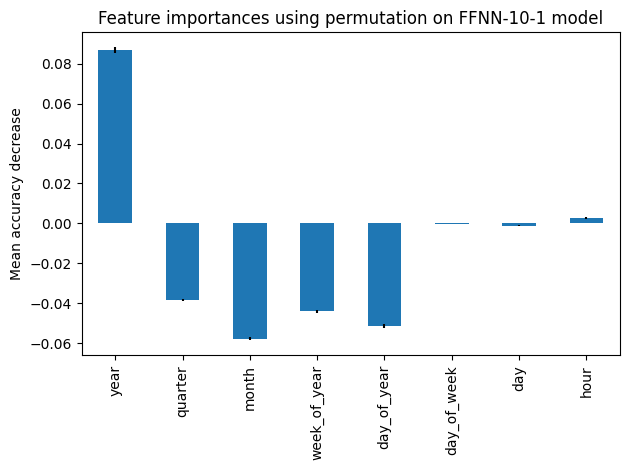

----------------
FFNN-10-5-1 model...
Epoch 1/10
1097/1097 [==============================] - 4s 3ms/step - loss: 0.4120
Epoch 2/10
1097/1097 [==============================] - 3s 3ms/step - loss: 0.3198
Epoch 3/10
1097/1097 [==============================] - 4s 3ms/step - loss: 0.3074
Epoch 4/10
1097/1097 [==============================] - 4s 4ms/step - loss: 0.2842
Epoch 5/10
1097/1097 [==============================] - 3s 3ms/step - loss: 0.2717
Epoch 6/10
1097/1097 [==============================] - 3s 3ms/step - loss: 0.2639
Epoch 7/10
1097/1097 [==============================] - 3s 3ms/step - loss: 0.2585
Epoch 8/10
1097/1097 [==============================] - 4s 4ms/step - loss: 0.2540
Epoch 9/10
1097/1097 [==============================] - 3s 3ms/step - loss: 0.2507
Epoch 10/10
275/275 [==============================] - 1s 2ms/step


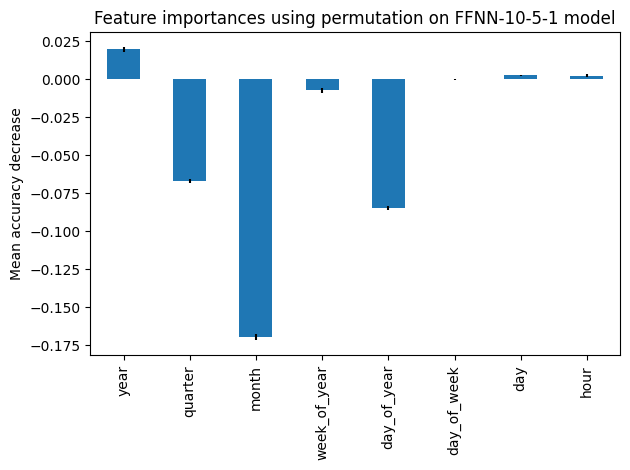

----------------
FFNN-10-5-2-1 model...
Epoch 1/10
1097/1097 [==============================] - 4s 3ms/step - loss: 0.5840
Epoch 2/10
1097/1097 [==============================] - 3s 3ms/step - loss: 0.4912
Epoch 3/10
1097/1097 [==============================] - 5s 4ms/step - loss: 0.4067
Epoch 4/10
1097/1097 [==============================] - 4s 3ms/step - loss: 0.3838
Epoch 5/10
1097/1097 [==============================] - 3s 3ms/step - loss: 0.3761
Epoch 6/10
1097/1097 [==============================] - 3s 3ms/step - loss: 0.3734
Epoch 7/10
1097/1097 [==============================] - 5s 4ms/step - loss: 0.3721
Epoch 8/10
1097/1097 [==============================] - 4s 3ms/step - loss: 0.3710
Epoch 9/10
1097/1097 [==============================] - 3s 3ms/step - loss: 0.3672
Epoch 10/10
275/275 [==============================] - 1s 4ms/step


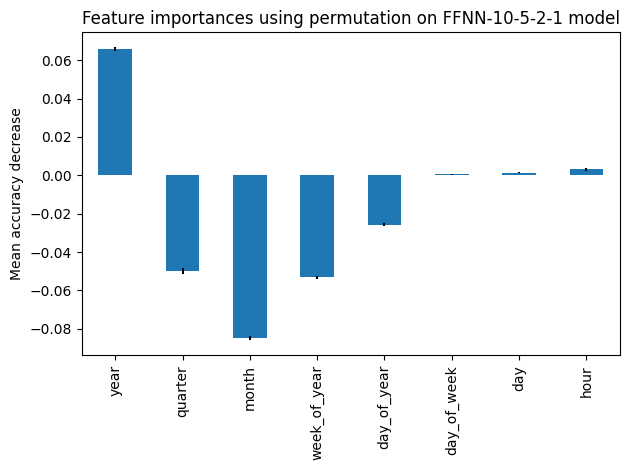

----------------
FFNN-20-10-5-1 model...
Epoch 1/10
1097/1097 [==============================] - 5s 3ms/step - loss: 0.6565
Epoch 2/10
1097/1097 [==============================] - 4s 3ms/step - loss: 0.4503
Epoch 3/10
1097/1097 [==============================] - 6s 6ms/step - loss: 0.3755
Epoch 4/10
1097/1097 [==============================] - 8s 7ms/step - loss: 0.3505
Epoch 5/10
1097/1097 [==============================] - 7s 6ms/step - loss: 0.3278
Epoch 6/10
1097/1097 [==============================] - 8s 8ms/step - loss: 0.3060
Epoch 7/10
1097/1097 [==============================] - 4s 4ms/step - loss: 0.2879
Epoch 8/10
1097/1097 [==============================] - 6s 5ms/step - loss: 0.2733
Epoch 9/10
1097/1097 [==============================] - 5s 4ms/step - loss: 0.2605
Epoch 10/10
275/275 [==============================] - 0s 2ms/step


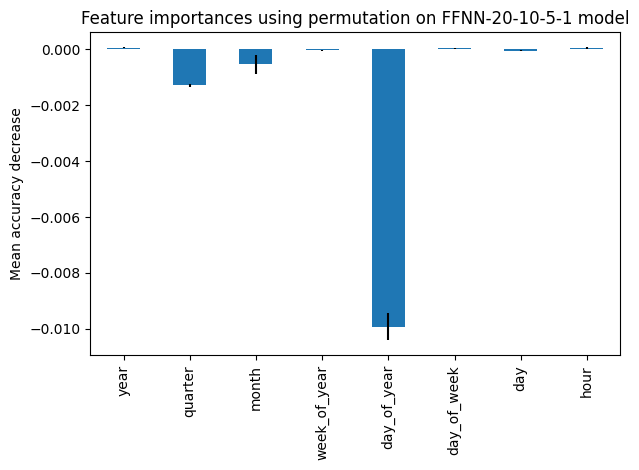

----------------
FFNN-20-10-5-2-1 model...
Epoch 1/10
1097/1097 [==============================] - 5s 3ms/step - loss: 0.7471
Epoch 2/10
1097/1097 [==============================] - 4s 4ms/step - loss: 0.5135
Epoch 3/10
1097/1097 [==============================] - 6s 5ms/step - loss: 0.3948
Epoch 4/10
1097/1097 [==============================] - 4s 4ms/step - loss: 0.3476
Epoch 5/10
1097/1097 [==============================] - 4s 4ms/step - loss: 0.3229
Epoch 6/10
1097/1097 [==============================] - 7s 6ms/step - loss: 0.2984
Epoch 7/10
1097/1097 [==============================] - 5s 4ms/step - loss: 0.2816
Epoch 8/10
1097/1097 [==============================] - 4s 3ms/step - loss: 0.2792
Epoch 9/10
1097/1097 [==============================] - 4s 3ms/step - loss: 0.2694
Epoch 10/10
275/275 [==============================] - 1s 4ms/step


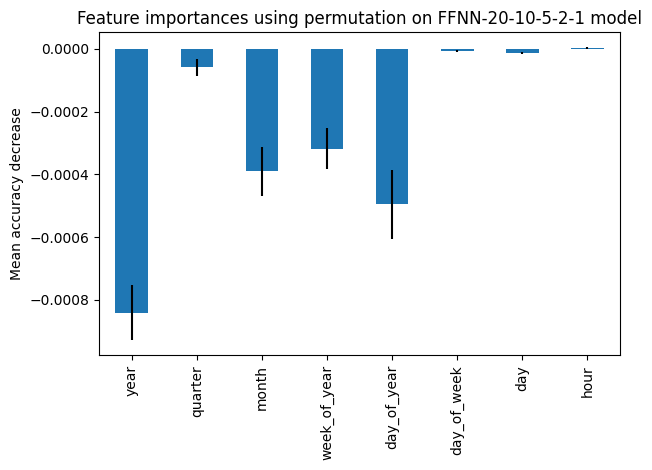

In [18]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

for name, model_function in dl_models:
    print('----------------')
    print(f'{name} model...')
    model = model_function(INPUT_SHAPE_FF)
    model.fit(
        x = x_train,
        y = y_train,
        batch_size = BATCH_SIZE,
        epochs = EPOCHS,
        shuffle = False,
        verbose = 1)
    result = permutation_importance(
        model,
        x_test,
        y_test,
        scoring = 'neg_mean_absolute_error',
        n_repeats = NUM_OF_SPLITS,
        random_state = RANDOM_STATE,
        n_jobs = 2)
    forest_importances = pd.Series(result.importances_mean, index = list(x_test.columns))
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr = result.importances_std, ax = ax)
    ax.set_title(f'Feature importances using permutation on {name} model')
    ax.set_ylabel('Mean accuracy decrease')
    fig.tight_layout()
    plt.show()

# Feature importance based on mean decrease in impurity (tree-based models)

In [ ]:
models = []
models.append(('RF', RandomForestRegressor(n_jobs = -1, random_state = RANDOM_STATE, bootstrap = False)))
models.append(('RF w/B.', RandomForestRegressor(n_jobs = -1, random_state = RANDOM_STATE, bootstrap = True)))
models.append(('XT', ExtraTreesRegressor(n_jobs = -1, random_state = RANDOM_STATE, bootstrap = False)))
models.append(('XT w/B.', ExtraTreesRegressor(n_jobs = -1, random_state = RANDOM_STATE, bootstrap = True)))
models.append(('ADA', AdaBoostRegressor(random_state = RANDOM_STATE)))

----------------
RF model...


C:\Users\dexp\AppData\Local\Temp\ipykernel_6136\2078846002.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


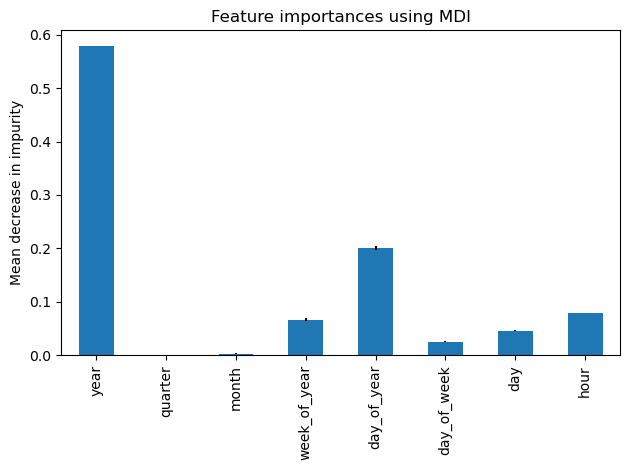

----------------
RF w/B. model...


C:\Users\dexp\AppData\Local\Temp\ipykernel_6136\2078846002.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


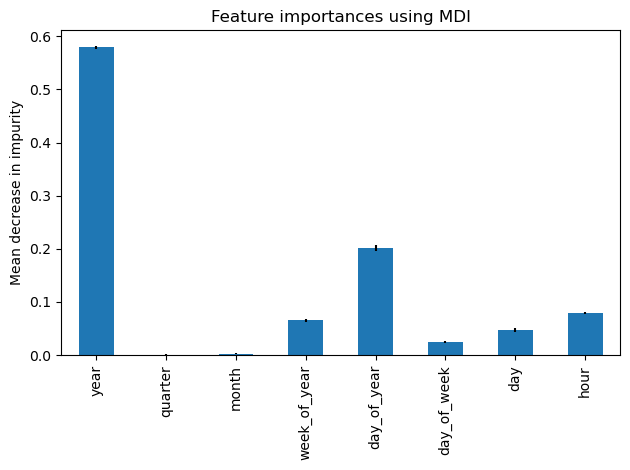

----------------
XT model...


C:\Users\dexp\AppData\Local\Temp\ipykernel_6136\2078846002.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


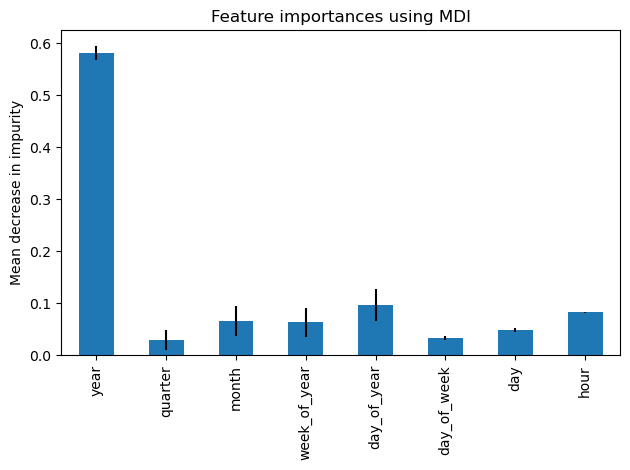

----------------
XT w/B. model...


C:\Users\dexp\AppData\Local\Temp\ipykernel_6136\2078846002.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


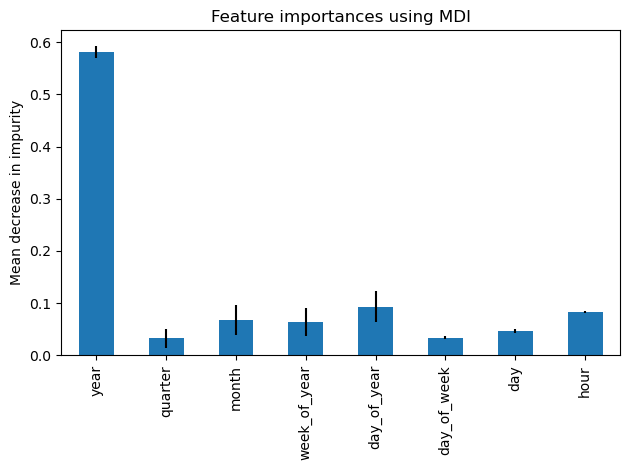

----------------
ADA model...


C:\Users\dexp\miniconda3\envs\energy\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


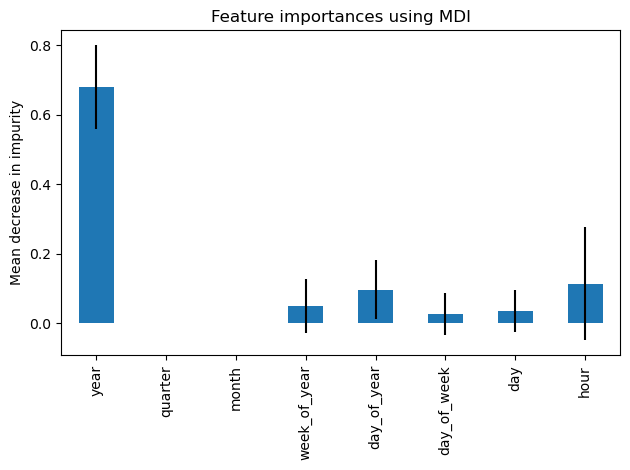

In [ ]:
for name, model in models:
    print('----------------')
    print(f'{name} model...')
    model.fit(x_train, y_train)
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)
    forest_importances = pd.Series(importances, index = list(x_test.columns))
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr = std, ax = ax)
    ax.set_title('Feature importances using MDI')
    ax.set_ylabel('Mean decrease in impurity')
    fig.tight_layout()
    plt.show()